<a href="https://colab.research.google.com/github/hammer1234567/Mullers-Clustering/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

In [0]:
dataset = pd.read_csv('/content/drive/My Drive/Kaggle/Mullers Dataset/mueller_report.csv')

In [0]:
dataset.head()

,page,line,text
0,1,1,U.S. Department of Justice
1,1,2,"AttarAe:,c\\'erlc Predtiet // Mtt; CeA1:ttiA"
2,1,3,Ma1:ertalPrn1:eetedUAder Fed. R. Crhtt. P. 6(e)
3,1,4,Report On The Investigation Into
4,1,5,Russian InterferenceIn The


In [0]:
delete_rows = list()
for index,row in dataset.iterrows():
  if type(row['text']) != str:
    delete_rows.append(index)

In [0]:
dataset.drop(delete_rows, inplace = True)

In [0]:
!pip install Unidecode
!pip install word2number

     |████████████████████████████████| 245kB 2.8MB/s 
  Created wheel for word2number: filename=word2number-1.1-cp36-none-any.whl size=5587 sha256=5e14c9a307699952e4a64ca70e3941758a3ec77d6ea8556571aaaf6238fbf693
  Stored in directory: /root/.cache/pip/wheels/46/2f/53/5f5c1d275492f2fce1cdab9a9bb12d49286dead829a4078e0e
Successfully built word2number


Data PreProcessing

In [0]:
from bs4 import BeautifulSoup
import spacy
import unidecode
from word2number import w2n
import gensim.downloader as api

nlp = spacy.load('en_core_web_sm')

In [0]:
def remove_accented_chars(text):
  text = unidecode.unidecode(text)
  return text

In [0]:
dataset['filter_text'] = dataset['text'].apply(lambda text: remove_accented_chars(text))

In [0]:
def treat_num(text):
  doc = nlp(text)
  try:
    tokens = [w2n.word_to_num(token.text) if token.pos_ == 'NUM' else token for token in doc]
    # print(tokens)
    rt_text = " ".join(str(token) for token in tokens)
  except:
    rt_text = str(doc)
  return rt_text

In [0]:
dataset['filter_text'] = dataset['filter_text'].apply(lambda text: treat_num(text))

In [0]:
dataset.head(10)

,page,line,text,filter_text
0,1,1,U.S. Department of Justice,U.S. Department of Justice
1,1,2,"AttarAe:,c\\'erlc Predtiet // Mtt; CeA1:ttiA","AttarAe:,c\\'erlc Predtiet // Mtt; CeA1:ttiA"
2,1,3,Ma1:ertalPrn1:eetedUAder Fed. R. Crhtt. P. 6(e),Ma1:ertalPrn1:eetedUAder Fed. R. Crhtt. P. 6(e)
3,1,4,Report On The Investigation Into,Report On The Investigation Into
4,1,5,Russian InterferenceIn The,Russian InterferenceIn The
5,1,6,2016 PresidentialElection,2016 PresidentialElection
6,1,7,Volume I of II,Volume I of II
7,1,8,"Special Counsel Robert S. Mueller, III","Special Counsel Robert S. Mueller, III"
8,1,9,Submitted Pursuant to 28 C.F.R. § 600.8(c),Submitted Pursuant to 28 C.F.R. SS 600.8(c)
9,1,10,"Washington, D.C.","Washington, D.C."


In [0]:
from nltk.stem import WordNetLemmatizer 
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer() 

dataset['filter_text'] = dataset['filter_text'].apply(lambda text: " ".join(lemmatizer.lemmatize(tokens) for tokens in text.split(" ")))


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
from nltk.corpus import stopwords
nltk.download('stopwords')

stop = stopwords.words("english")
dataset['filter_text'] = dataset['filter_text'].apply(lambda text: " ".join(x for x in text.split(" ") if x not in stop))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
dataset['filter_text'] = dataset['filter_text'].str.replace('[^\w\s]', '')
dataset['filter_text'] = dataset['filter_text'].str.replace('[\d-]', '')
dataset['filter_text'] = dataset['filter_text'].apply(lambda text: "".join(x.lower() for x in text).rstrip()) 

In [0]:
dataset.head()

,page,line,text,filter_text
0,1,1,U.S. Department of Justice,us department justice
1,1,2,"AttarAe:,c\\'erlc Predtiet // Mtt; CeA1:ttiA",attaraecerlc predtiet mtt ceattia
2,1,3,Ma1:ertalPrn1:eetedUAder Fed. R. Crhtt. P. 6(e),maertalprneeteduader fed r crhtt p e
3,1,4,Report On The Investigation Into,report on the investigation into
4,1,5,Russian InterferenceIn The,russian interferencein the


In [0]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
from nltk.tokenize import word_tokenize

def apply_tokenization(cols):
   text = cols[0]

   return word_tokenize(text)
dataset['final_text'] = dataset[['filter_text']].apply(apply_tokenization, axis = 1)

In [0]:
dataset.head()

,page,line,text,filter_text,final_text
0,1,1,U.S. Department of Justice,us department justice,"[us, department, justice]"
1,1,2,"AttarAe:,c\\'erlc Predtiet // Mtt; CeA1:ttiA",attaraecerlc predtiet mtt ceattia,"[attaraecerlc, predtiet, mtt, ceattia]"
2,1,3,Ma1:ertalPrn1:eetedUAder Fed. R. Crhtt. P. 6(e),maertalprneeteduader fed r crhtt p e,"[maertalprneeteduader, fed, r, crhtt, p, e]"
3,1,4,Report On The Investigation Into,report on the investigation into,"[report, on, the, investigation, into]"
4,1,5,Russian InterferenceIn The,russian interferencein the,"[russian, interferencein, the]"


In [0]:
import gzip
import shutil
with gzip.open('/content/drive/My Drive/Kaggle/Mullers Dataset/GoogleNews-vectors-negative300.bin.gz', 'rb') as f_in:
    with open('/content/drive/My Drive/Kaggle/Mullers Dataset/GoogleNews-vectors-negative300.bin', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

In [0]:
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('/content/drive/My Drive/Kaggle/Mullers Dataset/GoogleNews-vectors-negative300.bin', binary = True)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
model.vector_size

300

In [0]:
output = model['us', 'department', 'justice']

In [0]:
output.shape

(3, 300)

In [0]:
def apply_word2vec(cols):
  final_text = cols[0]

  return model[final_text]

In [0]:
dataset = 

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words="english", max_features=100)

tfidf_dataset = tfidf_vectorizer.fit_transform(dataset['filter_text'])

In [0]:
tfidf_dataset

<18747x11072 sparse matrix of type '<class 'numpy.float64'>'
	with 110968 stored elements in Compressed Sparse Row format>

In [0]:
from sklearn.preprocessing import normalize
tfidf_norm = normalize(tfidf_dataset)
x = tfidf_norm.toarray()

In [0]:
x.std()

0.08253045945250254

In [0]:
x = pd.DataFrame(tfidf_norm.todense())

In [0]:
x.head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [0]:
from sklearn.feature_extraction.text import HashingVectorizer

vectorizer = HashingVectorizer(n_features = 100)
sentence_vector = vectorizer.fit_transform(dataset['filter_text'])

In [0]:
from sklearn.preprocessing import normalize
sentence_norm = normalize(sentence_vector)

sentence_final = pd.DataFrame(sentence_norm.todense())

In [0]:
sentence_final.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.57735,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.57735,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,-0.57735,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.50000,0.0,0.0,0.00000,0.0,0.5,0.0,0.0,0.500000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.57735,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57735,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,-0.447214,0.0,0.00000,0.0,0.0,0.0,-0.447214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,-0.447214,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.447214,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.57735,0.0,0.0,-0.57735,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0


In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(perplexity = 20, random_state=101).fit_transform(sentence_final)

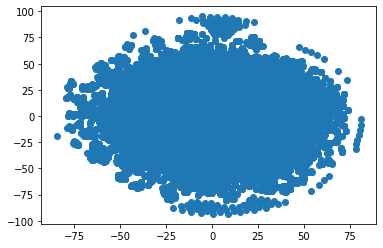

In [0]:
plt.scatter(tsne[:, 0], tsne[:, 1])

Dimensionality Reduction 

In [0]:
from sklearn.decomposition import PCA
pca = PCA(.90)

X = pca.fit_transform(x)

In [0]:
X.shape

(18747, 9)

In [0]:
from sklearn.manifold import TSNE

tsne = TSNE(random_state=101).fit_transform(x)

In [0]:
tsne.shape

(18747, 2)

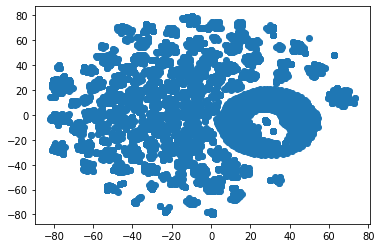

In [0]:
plt.scatter(tsne[:, 0], tsne[:, 1])

In [0]:
!pip install swat

     |████████████████████████████████| 54.9MB 65kB/s 


In [0]:
import swat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [0]:
data = pd.DataFrame(data = X)
data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684
0,0.973925,-0.003872,-0.002268,0.017813,0.018876,0.001344,0.009364,0.004562,-0.003877,0.002519,0.001475,0.000804,-0.002792,0.004669,-0.006138,0.005169,0.004378,0.005182,0.001017,0.006395,0.002132,-0.001844,0.002574,0.002722,0.000576,0.001938,-0.000814,0.001750,0.003626,-0.001133,-0.001163,-0.000256,0.003633,-0.001302,-0.002177,0.000553,0.006943,-0.001642,0.001196,0.001092,...,-0.000370,-0.000243,0.000406,-0.000257,0.000149,-0.000261,0.000231,-0.000345,-0.000333,-0.000016,0.000044,0.000433,-0.000177,0.000240,0.000387,-0.000005,-0.000063,0.000095,-0.000215,-0.000658,0.000263,-0.000306,-0.000150,-0.000141,0.000099,-0.000528,0.000065,0.000195,-0.000039,-0.000061,0.000171,-0.000052,-0.000032,-0.000149,-0.000076,-0.000205,0.000482,0.000053,-0.000463,0.000003
1,-0.019999,0.011236,-0.023351,-0.031148,-0.044851,0.008332,-0.017804,0.005645,0.009516,-0.029065,-0.022234,0.002786,0.006376,-0.000043,0.005634,-0.009697,-0.005885,0.000423,-0.004126,-0.011859,-0.006486,0.002298,0.002055,-0.006103,-0.004211,0.000722,0.005113,-0.002033,-0.006252,0.004320,0.005030,-0.003151,0.002361,0.002394,0.004129,0.002288,0.003487,-0.008255,-0.007020,-0.005588,...,0.022194,-0.009691,-0.045464,-0.005583,0.034919,-0.006930,-0.036235,0.029086,-0.039292,0.001189,-0.014685,0.038628,0.046553,-0.009086,-0.010810,-0.017407,0.020195,-0.037840,0.021442,0.019859,0.018686,0.008670,0.002761,-0.046567,0.039390,-0.017812,0.026659,-0.025546,-0.004363,0.012510,-0.041991,0.023100,-0.009676,-0.037438,0.033959,-0.009960,-0.043839,0.013926,0.009394,-0.008778
2,-0.022856,0.016683,-0.037489,-0.053375,-0.084748,0.021191,-0.054626,0.018045,0.043017,-0.133639,-0.140406,0.021001,0.054110,0.109988,-0.104645,0.068754,0.028922,0.003645,0.010217,0.024212,0.013186,-0.006370,0.004826,0.002383,0.001504,-0.004513,0.001622,0.000940,-0.002086,0.000512,0.001212,0.002235,0.000560,0.004296,0.004027,0.001925,-0.000161,-0.000327,-0.001030,-0.000364,...,-0.002322,0.007039,-0.005370,0.004811,0.001480,0.005753,-0.004171,-0.001357,-0.004372,-0.004499,0.001438,0.001638,0.004721,-0.008473,0.008768,-0.001624,0.013359,-0.004935,-0.007312,0.005511,0.000669,0.000528,0.004973,-0.011246,0.009487,-0.009128,0.006692,0.002445,0.003984,0.003399,-0.008726,0.000378,0.006165,-0.015493,0.013234,-0.007065,-0.022715,0.009391,0.005600,-0.001965
3,-0.028031,-0.008056,0.090442,-0.031907,0.001594,-0.137964,-0.121196,-0.210378,0.022289,0.229447,-0.138595,-0.066971,0.262828,0.008525,0.109438,0.061347,0.088912,-0.133652,0.122504,-0.161027,0.042473,-0.032294,0.014311,0.042401,0.034641,-0.005592,0.025257,0.015024,0.019300,-0.004787,0.015823,-0.006542,0.019249,-0.010236,0.050494,-0.005709,0.024611,-0.024939,0.038325,-0.011128,...,-0.007335,0.010543,-0.005435,0.009011,0.005416,0.000875,-0.007886,-0.004313,0.002625,-0.003422,-0.003570,0.009573,-0.004905,-0.004630,0.002121,-0.006586,-0.002697,-0.008697,-0.009097,-0.007603,-0.005176,0.008470,-0.006248,0.000984,-0.002080,-0.001616,0.006497,0.010298,0.007614,-0.007140,0.002422,0.001252,-0.012953,-0.002209,-0.004412,-0.012498,0.000822,0.003328,-0.001099,0.010898
4,-0.036949,-0.004092,-0.104090,-0.078276,0.043908,-0.064389,-0.159048,0.027122,-0.164365,0.207963,0.162927,0.391582,-0.177296,-0.024733,-0.181001,0.410065,-0.206761,0.116621,0.172464,-0.179852,0.074533,-0.080532,-0.042425,0.030571,-0.146885,0.090763,-0.009122,0.009914,0.051026,-0.040889,-0.010598,0.030002,0.052886,-0.044718,0.004516,-0.047187,0.115170,-0.068756,0.020870,0.005624,...,-0.006838,-0.005225,0.006197,0.001506,-0.013763,-0.007160,0.000833,-0.000316,0.003230,0.000560,0.003928,0.000546,-0.002603,-0.007276,0.000369,0.002756,-0.002631,0.000547,-0.005519,-0.002483,0.005550,-0.001113,0.000312,-0.001861,-0.001499,-0.001938,0.003252,0.003584,-0.006973,0.0038

In [0]:
print(pca.explained_variance_ratio_.sum())

0.9001682724421944


Using Elbow Method to find optimal number of clusters

In [0]:
from sklearn.cluster import KMeans

def Calculate_WSS(points, kmax):
  sse = []

  for k in range(1, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(points)

    centroids = kmeans.cluster_centers_
    pred_clusters = kmeans.predict(points)

    curr_see = 0

    for i in range(len(points)):
      curr_center = centroids[pred_clusters[i]]
      curr_see += (points[i, 0] - curr_center[0]) ** 2 + (points[i, 1] - curr_center[1]) ** 2
      
    sse.append(curr_see)
  return sse

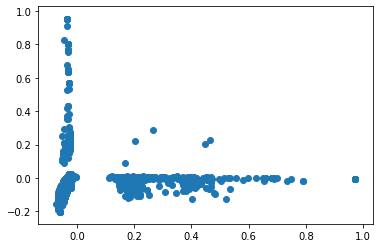

In [0]:
from matplotlib import pyplot as plt

plt.scatter(X[:, 0], X[:, 1])

In [0]:
result

[669.3513691675881,
 231.87617432938418,
 490.8137553838405,
 231.70370431895168,
 55.12024132451902,
 216.86899967353187,
 228.42440203461263,
 225.97893048559283,
 52.73335096989925,
 53.802284719455876,
 55.98615873360009,
 50.92813223158704,
 50.214740340403125,
 46.054205583552054,
 45.04350614845437,
 221.43625725733827,
 49.40982307779605,
 46.011594051821774,
 51.16662367174865,
 45.001782000892334,
 49.11323589900784,
 48.31640626149039,
 47.02815682943688,
 45.474621378788484,
 44.76366996484391]

In [0]:
result = Calculate_WSS(X, 25)

In [0]:
list2 = list()
for i in range(1, 26):
  list2.append(i)

list2

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25]

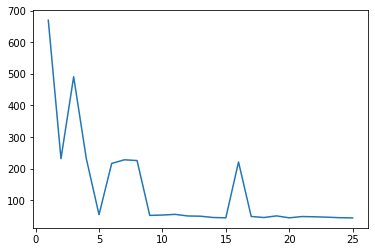

In [0]:
import matplotlib.pyplot as plt

plt.plot(list2, result)

optimum k here seems to be 5

Using Silhoutte algorithm to find the optimum number of clusters

For n_clusters = 5 The average silhouette_score is : 0.09413207686291418
For n_clusters = 6 The average silhouette_score is : 0.09969654339098001
For n_clusters = 7 The average silhouette_score is : 0.10459153024088474


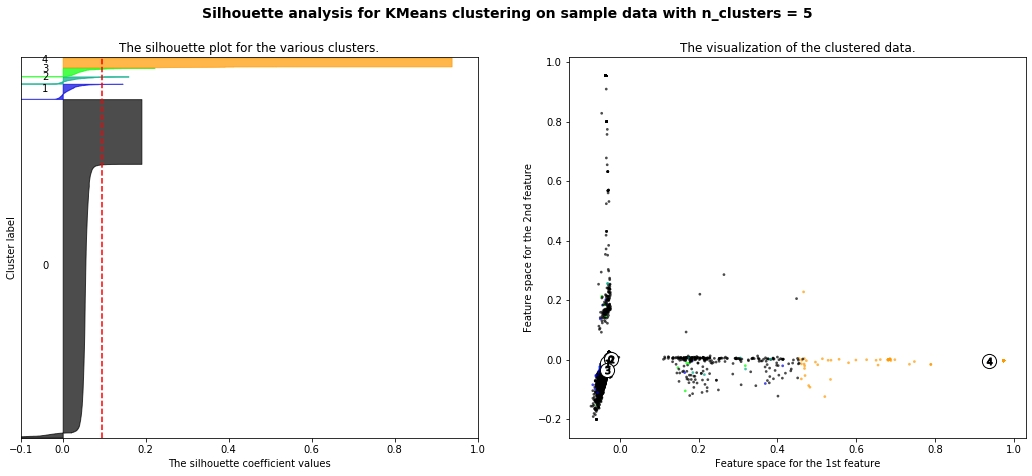

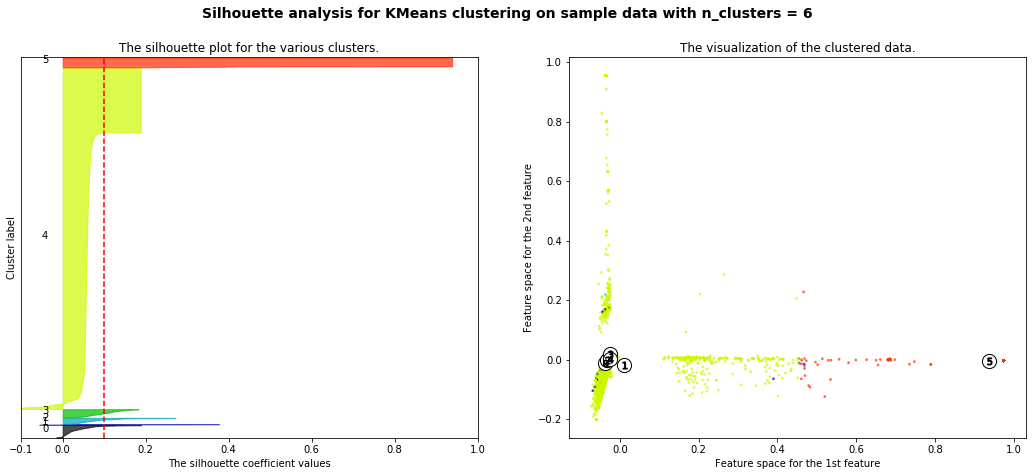

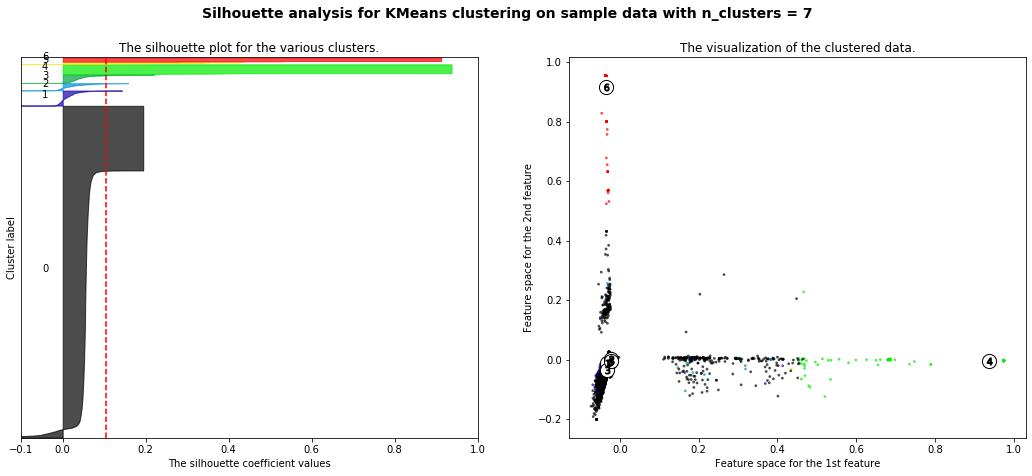

In [0]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


range_n_clusters = [ 5, 6, 7]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [0]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 21, max_iter = 600)

fitted = kmeans.fit(X)
predicted_values = kmeans.predict(X)



Plotting the cluster visualization on a 2d space

The data can also be visualized efficiently using tsne and pca but very less time due to end sem exams 

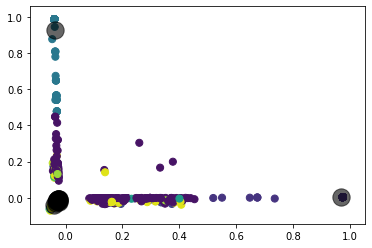

In [0]:
plt.scatter(X[:, 0], X[:, 1], c=predicted_values, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1],c='black', s=300, alpha=0.6);

Fining the important words which effected cluster the most

In [0]:
import numpy as np

def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = tfidf_vectorizer.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(X, predicted_values, 15)

In [0]:
dfs[15]

,features,score
0,impeding,0.556889
1,investigator,0.449970
2,proceeding,0.390834
3,communication,0.374020
4,information,0.313825
5,official,0.310278
6,evgeny,0.000000
7,evolved,0.000000
8,evgeniy,0.000000
9,exa,0.000000
